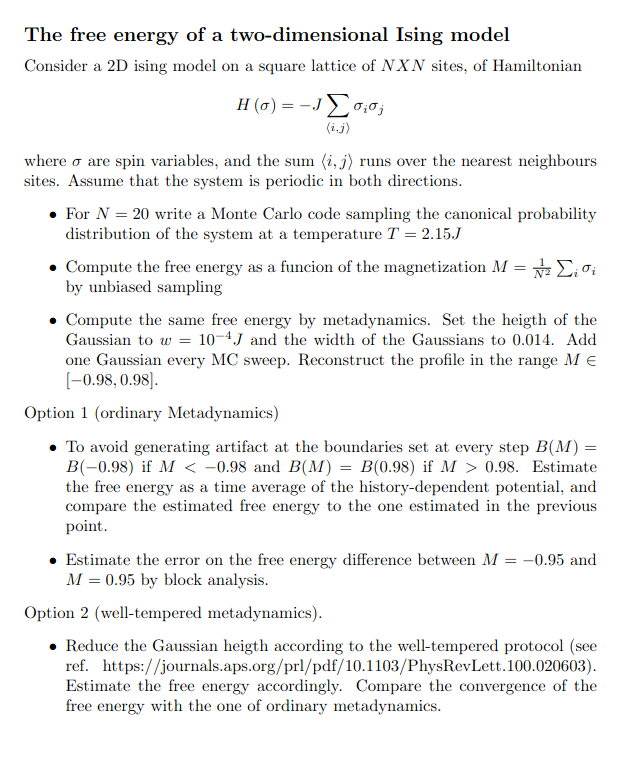

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
# Define parameters 
N = 20 # Number of sites along one dimension
J = 1 # Coupling constant
kbT = 2.15*J # Temperature
n_steps = 10000 # Default number of time steps

In [11]:
# Define the Hamiltonian
def H(spins, J):
    ''' Returns the Hamiltonian of the system. It is computed as the sum of the interactions between nearest neighbours. '''
    # Compute interaction with each neighbour in a parallelised fashion by matrices element-wise multiplication. np.roll accounts for PBCs.
    H = spins*np.roll(spins,1, axis=1) + spins*np.roll(spins,-1, axis=1) + spins*np.roll(spins,-1, axis=0) + spins*np.roll(spins,1, axis=0)
    return -J*H/2 # We divide to avoid double counting

# Define magnetisation
def M_compute(spins):
    ''' Returns the total magnetisation of the system, divided by the number of sites. '''
    return np.sum(spins)/N**2

Unbiased Simulation

In [12]:
# Metropolis with unbiased potential
# Si potrebbe ottimizzare calcolando l'energia solo per i primi vicini, tanto solo loro cambiano
def run_unbiased(n_steps, spins = None):
    if spins is None:
        spins = np.random.choice([-1,1], size=(N,N)) # Random initial configuration
    E_0 = np.sum(H(spins, J)) # Initial energy
    # Si potrebbe ottimizzare calcolando l'energia solo per i primi vicini, tanto solo loro cambiano
    M_time_series = [ M_compute(spins), ] # List to store the magnetisation at each time step

    acceptance = 0
    for _ in tqdm(range(n_steps)):
        # Move is proposed by flipping a random spin
        proposed_spins = spins.copy()
        # Randomly choose a spin to flip
        i = np.random.randint(N)
        j = np.random.randint(N)
        proposed_spins[i,j] *= -1
        # Compute the new energy
        E_proposed = np.sum(H(proposed_spins, J))
        alpha = np.exp(-(E_proposed-E_0)/kbT) # Acceptance computed as ratio of probabilities. Proposal matrix is symmetric, so it cancels out
        alpha = min(1, alpha)
        # Accept or reject the move
        if np.random.random() < alpha:  # Accept
            spins = proposed_spins
            E_0 = E_proposed
            acceptance += 1
        else: # Reject
            pass
        M_time_series.append(M_compute(spins))
    
    print(f'Acceptance rate: {acceptance/n_steps}')

    return M_time_series


In [13]:
M_time_series = run_unbiased(n_steps=200000)

100%|██████████| 200000/200000 [00:25<00:00, 7702.77it/s]

Acceptance rate: 0.134325


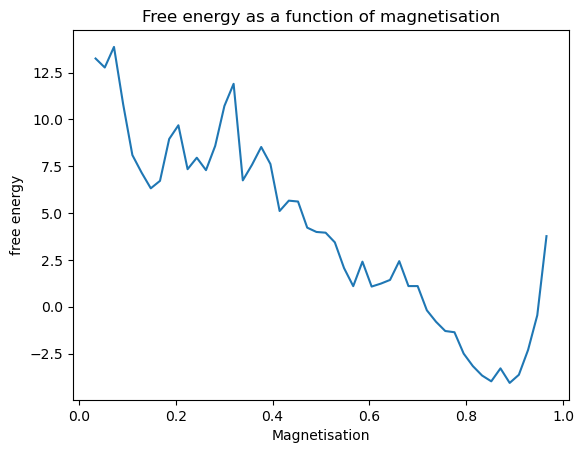

In [14]:
# Histogram of free energy as a function of magnetisation
# Free energy is computed as -kbT*log(p(m))
# p(m) is computed as the histogram of the magnetisation time series

# Compute histogram
hist, bin_edges = np.histogram(M_time_series, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
# Compute free energy
free_energy = -kbT*np.log(hist)

# Plot
plt.plot(bin_centers, free_energy)

plt.xlabel('Magnetisation')
plt.ylabel('free energy')
plt.title('Free energy as a function of magnetisation')
plt.show()

Metadynamics run

In [15]:
# Metadynamics params
w = 1e-4*J # Height of the Gaussian
width = 0.014 # Width of the Gaussian
M_domain = np.linspace(-1,1,N**2 + 1, endpoint=True) # Domain of the magnetisation

In [16]:
def add_gaussian(bias,M,w,width):
    ''' Adds a Gaussian centered on M to the bias potential. '''
    # Compute gaussian centered on M on each point of the domain of M
    gaussian = w*np.exp(-(M_domain-M)**2/(2*width**2))
    # Add the Gaussian to the bias potential
    bias += gaussian
    return bias

def get_bias_index(M):
    ''' Returns the index of the bias potential corresponding to the magnetisation M. '''
    # We need to map the magnetization domain to integers. To do so the lowest posible magnetization is associated to 0, the highest to N**2+1
    return np.round((M*N**2 + N**2)/2).astype(int)

def get_bias(bias,M):
    ''' Returns the bias potential for a given magnetisation. '''
    M_index = get_bias_index(M)
    return bias[M_index]

def propose_move(spins, spins_flip_per_step):
   '''Proposes a move by flipping random spins. Number of spins flipped is given by spins_flip_per_step.
    Returns the proposed spins, energy and magnetisation. '''
   proposed_spins = spins.copy()
   # Randomly choose the spins to flip
   for _ in range(spins_flip_per_step):
       i = np.random.randint(N)
       j = np.random.randint(N)
       proposed_spins[i,j] *= -1
   
   # Compute the new energy and magnetisation
   E_proposed = np.sum(H(proposed_spins, J))
   M_proposed = M_compute(proposed_spins)
   return proposed_spins, E_proposed, M_proposed 

def initialize(metadynamics, bias, spins, M_time_series):
    ''' Initializes the E_0, M, M_time_series and bias. If metadynamics is True, initializes the bias potential. '''
    if metadynamics:
        # Raise error if only one is given between bias and spins
        if (bias is None) != (spins is None) != (M_time_series is None):
            raise ValueError('If metadynamics is True, both bias and spins must be given or none of them.')
    
    if spins is None:
        spins = np.random.choice([-1,1], size=(N,N)) # Random initial configuration
    
    M = M_compute(spins) # Initial magnetisation
    if M_time_series is None:
        M_time_series = [ M_compute(spins), ] # List to store the magnetisation at each time step
    else:
        M_time_series = list(M_time_series)
    
    E_0 = np.sum(H(spins, J)) # Initial energy
    # initialize bias potential
    if metadynamics:
        if bias is None:    # If no bias is given, initialize it to zero. Otherwise, use the given initial condition. Useful for continuing a simulation
            bias = np.zeros(N**2+1) # Bias potential as a function of magnetisation
    return spins, E_0, M, M_time_series, bias


def run_simulation(n_steps, spins = None, metadynamics = True, spins_flip_per_step = 1, bias = None, M_time_series = None):
    ''' Runs a simulation of Metropolis MC. If metadynamics is True, runs a bias is added to at each step.'''

    # Initialize the following variables
    spins, E_0, M, M_time_series, bias = initialize(metadynamics, bias, spins, M_time_series)
    
    # Metropolis
    acceptance = 0
    for _ in tqdm(range(n_steps)):
        # Move is proposed by flipping some random spins
        proposed_spins, E_proposed, M_proposed = propose_move(spins, spins_flip_per_step)
        
        # Compute the acceptance
        if metadynamics:
            delta_E = E_proposed-E_0 + get_bias(bias,M_proposed) - get_bias(bias,M)
        else:
            delta_E = E_proposed-E_0
        alpha = np.exp(-delta_E/kbT) # Acceptance computed as ratio of probabilities. Proposal matrix is symmetric, so it cancels out
        alpha = min(1, alpha)

        # Accept or reject the move
        # !! Is it right to reject a move if the magnetisation is outside the domain? !!
        if np.random.random() < alpha:  # Accept. We avoid the edges of the domain.
            # Update the variables
            spins = proposed_spins
            E_0 = E_proposed
            M = M_proposed
            acceptance += 1
        else: # Reject
            pass
        
        if metadynamics:
            # Update bias for each spin
            bias = add_gaussian(bias,M,w,width)

            # Avoid biasing the edges of the domain. We set B[<-0.98]=B[-0.98] and B[>0.98]=B[0.98]
            bias[:get_bias_index(-0.98)] = bias[get_bias_index(-0.98)]
            bias[get_bias_index(0.98):] = bias[get_bias_index(0.98)]

        M_time_series.append(M)
        
    print('Acceptance rate: {:.2f}%'.format(100*acceptance/n_steps))
    np.savetxt('final_spins.txt', spins)
    np.savetxt('M_time_series.txt', M_time_series)
    np.savetxt('bias.txt', bias)    
    # Assert that bias is not None if metadynamics is True and viceversa
    assert bias is not None if metadynamics else bias is None

    return M_time_series, bias


100%|██████████| 100000/100000 [00:23<00:00, 4259.82it/s]


Acceptance rate: 16.45%
Simulation 1/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4456.39it/s]


Acceptance rate: 14.43%
Simulation 2/50 done


100%|██████████| 100000/100000 [00:23<00:00, 4338.09it/s]


Acceptance rate: 13.03%
Simulation 3/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4382.19it/s]


Acceptance rate: 13.09%
Simulation 4/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4417.97it/s]


Acceptance rate: 12.60%
Simulation 5/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4381.39it/s]


Acceptance rate: 16.37%
Simulation 6/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4432.32it/s]


Acceptance rate: 18.57%
Simulation 7/50 done


100%|██████████| 100000/100000 [00:21<00:00, 4583.22it/s]


Acceptance rate: 14.58%
Simulation 8/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4356.03it/s]


Acceptance rate: 11.35%
Simulation 9/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4508.99it/s]


Acceptance rate: 17.78%
Simulation 10/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4373.35it/s]


Acceptance rate: 19.90%
Simulation 11/50 done


100%|██████████| 100000/100000 [00:23<00:00, 4299.58it/s]


Acceptance rate: 20.23%
Simulation 12/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4397.04it/s]


Acceptance rate: 18.42%
Simulation 13/50 done


100%|██████████| 100000/100000 [00:21<00:00, 4569.07it/s]


Acceptance rate: 16.12%
Simulation 14/50 done


100%|██████████| 100000/100000 [00:21<00:00, 4584.66it/s]


Acceptance rate: 22.07%
Simulation 15/50 done


100%|██████████| 100000/100000 [00:21<00:00, 4597.72it/s]


Acceptance rate: 21.26%
Simulation 16/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4453.42it/s]


Acceptance rate: 11.22%
Simulation 17/50 done


100%|██████████| 100000/100000 [00:21<00:00, 4703.22it/s]


Acceptance rate: 13.43%
Simulation 18/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4377.07it/s]


Acceptance rate: 13.26%
Simulation 19/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4400.51it/s]


Acceptance rate: 14.80%
Simulation 20/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4430.92it/s]


Acceptance rate: 14.88%
Simulation 21/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4422.33it/s]


Acceptance rate: 12.11%
Simulation 22/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4464.74it/s]


Acceptance rate: 11.55%
Simulation 23/50 done


100%|██████████| 100000/100000 [00:21<00:00, 4700.30it/s]


Acceptance rate: 13.92%
Simulation 24/50 done


100%|██████████| 100000/100000 [00:21<00:00, 4739.45it/s]


Acceptance rate: 15.99%
Simulation 25/50 done


100%|██████████| 100000/100000 [00:21<00:00, 4616.12it/s]


Acceptance rate: 13.75%
Simulation 26/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4492.48it/s]


Acceptance rate: 16.25%
Simulation 27/50 done


100%|██████████| 100000/100000 [00:23<00:00, 4207.34it/s]


Acceptance rate: 19.08%
Simulation 28/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4454.15it/s]


Acceptance rate: 15.35%
Simulation 29/50 done


100%|██████████| 100000/100000 [00:23<00:00, 4340.65it/s]


Acceptance rate: 19.84%
Simulation 30/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4411.80it/s]


Acceptance rate: 20.20%
Simulation 31/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4417.04it/s]


Acceptance rate: 22.05%
Simulation 32/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4462.57it/s]


Acceptance rate: 17.35%
Simulation 33/50 done


100%|██████████| 100000/100000 [00:23<00:00, 4188.45it/s]


Acceptance rate: 15.71%
Simulation 34/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4420.46it/s]


Acceptance rate: 22.04%
Simulation 35/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4480.94it/s]


Acceptance rate: 16.70%
Simulation 36/50 done


100%|██████████| 100000/100000 [00:22<00:00, 4372.86it/s]


Acceptance rate: 11.32%
Simulation 37/50 done


100%|██████████| 100000/100000 [00:23<00:00, 4340.68it/s]


Acceptance rate: 20.62%
Simulation 38/50 done


100%|██████████| 100000/100000 [00:20<00:00, 4951.14it/s]


Acceptance rate: 18.55%
Simulation 39/50 done


100%|██████████| 100000/100000 [00:18<00:00, 5322.85it/s]


Acceptance rate: 22.72%
Simulation 40/50 done


100%|██████████| 100000/100000 [00:18<00:00, 5322.04it/s]


Acceptance rate: 20.81%
Simulation 41/50 done


100%|██████████| 100000/100000 [00:18<00:00, 5295.42it/s]


Acceptance rate: 17.07%
Simulation 42/50 done


100%|██████████| 100000/100000 [00:19<00:00, 5241.59it/s]


Acceptance rate: 19.36%
Simulation 43/50 done


100%|██████████| 100000/100000 [00:19<00:00, 5242.07it/s]


Acceptance rate: 17.50%
Simulation 44/50 done


100%|██████████| 100000/100000 [00:19<00:00, 5108.05it/s]


Acceptance rate: 16.95%
Simulation 45/50 done


100%|██████████| 100000/100000 [00:18<00:00, 5386.09it/s]


Acceptance rate: 11.37%
Simulation 46/50 done


100%|██████████| 100000/100000 [00:18<00:00, 5330.38it/s]


Acceptance rate: 21.47%
Simulation 47/50 done


100%|██████████| 100000/100000 [00:18<00:00, 5302.70it/s]


Acceptance rate: 20.94%
Simulation 48/50 done


100%|██████████| 100000/100000 [00:18<00:00, 5318.58it/s]


Acceptance rate: 20.85%
Simulation 49/50 done


100%|██████████| 100000/100000 [00:18<00:00, 5304.09it/s]


Acceptance rate: 23.20%
Simulation 50/50 done


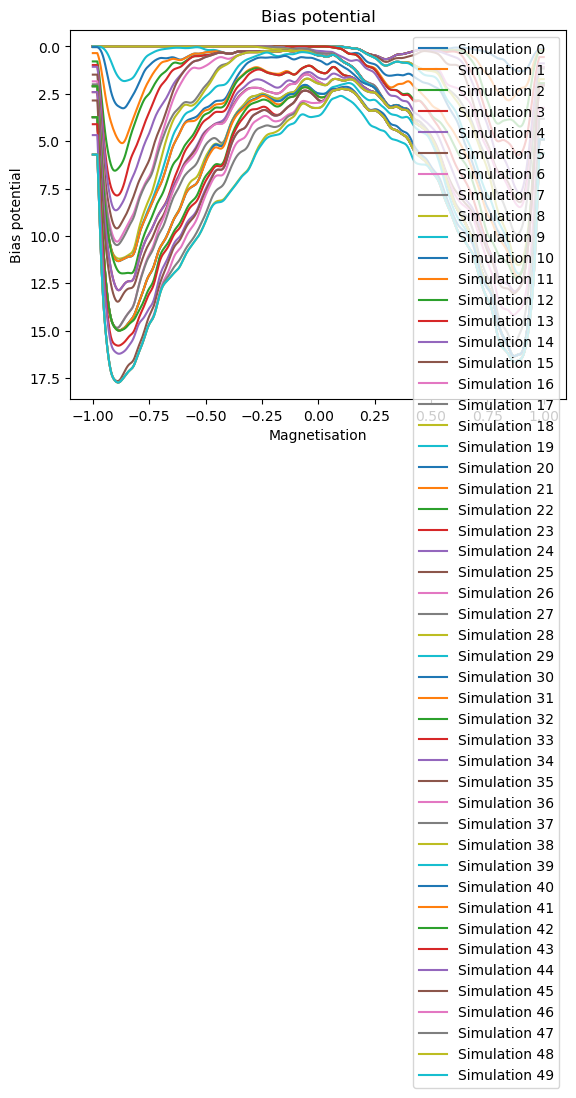

In [21]:
# Continue last simulation?
continue_last_simulation = False
if continue_last_simulation:
    initial_spins = np.loadtxt('final_spins.txt')
    initial_bias = np.loadtxt('bias.txt')
    initial_M_time_series = np.loadtxt('M_time_series.txt')
else:
    initial_spins = None
    initial_bias = None
    initial_M_time_series = None
# Let's plot the evolution of the bias potential.
# To do so we launch consecutive simulations in loop and plot the bias potential at the end of each simulation.
n_simulations = 50
n_steps = int(1e5)
plt.figure()
plt.title('Bias potential')
plt.xlabel('Magnetisation')
plt.ylabel('Bias potential')
plt.gca().invert_yaxis()
M_domain = np.linspace(-1,1,N**2+1)
for i_sim in range(n_simulations):
    if i_sim != 0:
        initial_spins = np.loadtxt('final_spins.txt')
        initial_bias = np.loadtxt('bias.txt')
        initial_M_time_series = np.loadtxt('M_time_series.txt')
    _, bias = run_simulation(n_steps=n_steps, metadynamics=True, bias=initial_bias, spins=initial_spins, M_time_series=initial_M_time_series)

    # Plot the new bias potential with the previous ones
    plt.plot(M_domain, bias, label = 'Simulation {}'.format(i_sim))
    plt.legend()
    plt.savefig('bias_potential.png')

    print(f'Simulation {i_sim+1}/{n_simulations} done')

In [ ]:
spins_sam= np.loadtxt('spins_sam.txt')
print(np.sum(H(spins_sam,J)))

-40.0
